In this notebook, our objective is to build a model that can extract entities (person, location, organization) from Online Chinese news paragraphs.

After doing a literature review, the following decisions were made:

- **Dataset**: We will use a [dataset](https://github.com/GuocaiL/nlp_corpus/tree/main/open_ner_data/people_daily) extracted from China's People Daily newspaper for training and evaluating our models. This is because the dataset is relevant to our use case and also contains the entities we want to extract.

- **Pretrained Models**: We will use pretrained models in SpaCy due to SpaCy's simplicity and design for production use.

- **Annotation scheme**: We will largely follow the annotation scheme of OntoNotes 5.0, but we'll combine GPE and Location together.

   > "PERSON": People, including fictional

   > "ORG": Companies, agencies, institutions, etc.

   > "GPE": Countries, cities, states and all other locations including mountain ranges and bodies of water

In [1]:
# Create virtual environment, install packages
!sudo apt-get install python3.8-venv
!source .env/bin/activate
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download zh_core_web_sm
!pip install scikit-multilearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  python-pip-whl
The following NEW packages will be installed:
  python-pip-whl python3.8-venv
0 upgraded, 2 newly installed, 0 to remove and 21 not upgraded.
Need to get 1,811 kB of archives.
After this operation, 2,339 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python-pip-whl all 20.0.2-5ubuntu1.7 [1,805 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3.8-venv amd64 3.8.10-0ubuntu1~20.04.6 [5,448 B]
Fetched 1,811 kB in 1s (2,361 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf

In [2]:
import spacy
from spacy import displacy
from spacy.tokens import Span, SpanGroup, DocBin
from spacy.training import *
from spacy.scorer import Scorer
from spacy.util import filter_spans, minibatch, compounding
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import json
import string
import os
import re
from collections import defaultdict, Counter
from skmultilearn.model_selection import iterative_train_test_split

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Mounted at /content/drive


In [3]:
FOLDER_PATH = "/content/drive/MyDrive/Colab Notebooks/"
PEOPLE_DAILY_FILE = "people_daily_ner.txt"

## Preprocess data + Compute statistics

We first have to read and preprocess data into suitable formats. 

There are a series of tasks we need to do:

- Obtain a list of dictionaries for SpaCy training later. This is because SpaCy training requires a specific format.

- Obtain lists of text and entities for train-test split

- Obtain entity and document counts 

- Obtain samples to check on specific entity types

In [4]:
label_mapping = {'DATE': 1, 'PERSON': 2, 'ORG': 3, 'GPE': 4}

def init_dict_cnt():
  """Initialise dictionary for counting documents with entity types"""
  return {'EMPTY': 0, 'DATE': 0, 'PERSON': 0, 'ORG': 0, 'GPE': 0}

def read_and_process_data(file_path):
  """Reads text file and returns lists and dictionaries for training, train-test-split, computing statistics and samples
     Input: Text file path

     Output:
        - spacy_data: list of dictionaries eg. {'text': '迈向充满希望的新世纪——一九九八年新年讲话(附图片1张)', 'entities': [(12, 19, 'DATE')]}
        - text_list_split: nested list of news text for train-test-split eg. [['迈向充满希望的新世纪——一九九八年新年讲话(附图片1张)']]
        - entities_list_split: nested list of entity labels for train-test-split eg. [[1]]
        - entities_list_stats: nested list of entity names for computing statistics eg. [['DATE']]
        - doc_count: dictionary containing document counts of entity types
        - samples_dict: dictionary containing samples of each entity type
  """
  doc_count = init_dict_cnt()

  spacy_data = []
  text_list_split = []
  entities_list_split = []          
  entities_list_stats = []
  samples_dict = {'DATE': [], 'PERSON': [], 'ORG': [], 'GPE': []}

  file_path = FOLDER_PATH + PEOPLE_DAILY_FILE
  with open(file_path) as f:
      text = ""
      lines = 0
      for word_line in f:
        word_dict = json.loads(word_line)
        temp_dict = {}
        entity_label_list_split = []
        entity_label_list_stats = []

        temp_dict['text'] = word_dict['text']
        temp_dict['entities'] = []
        if len(word_dict['entity_list']) > 0:  

            for annotation in word_dict['entity_list']:
                start = annotation['entity_index']['begin']
                end = annotation['entity_index']['end']
                label = annotation['entity_type'].upper()
                annotation_entity = annotation['entity']
                temp_dict['entities'].append((start, end, label))

                entity_label_list_split.append(label_mapping[label])
                entity_label_list_stats.append(label)
                samples_dict[label].append(annotation_entity)

            for label in set(entity_label_list_stats):
                doc_count[label] += 1

        else:
          entity_label_list_split.append(0)
          entity_label_list_stats.append("EMPTY")
          doc_count['EMPTY'] += 1

        spacy_data.append(temp_dict)
        text_list_split.append([word_dict['text']])
        entities_list_split.append(entity_label_list_split)
        entities_list_stats.append(entity_label_list_stats)
    
  return spacy_data, text_list_split, entities_list_split, entities_list_stats, doc_count, samples_dict

In [5]:
spacy_data, text_list_split, entities_list_split, entities_list_stats, doc_count, samples_dict = read_and_process_data(FOLDER_PATH + PEOPLE_DAILY_FILE)

In [ ]:
len(text_list_split)

19359

As seen above, we have 19.4K texts in our dataset.

  Entity Type  Entity Count
0        DATE         16035
3       EMPTY          4650
4         GPE         27588
1         ORG          3578
2      PERSON         19392


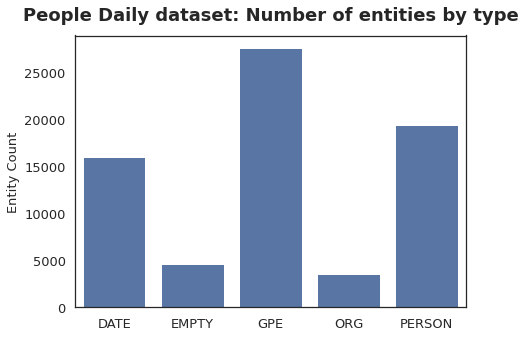

In [ ]:
entities_list_stats_flattened = list(np.concatenate(entities_list_stats).flat)
entity_count_type = Counter(entities_list_stats_flattened).keys()
entity_count_values = Counter(entities_list_stats_flattened).values()

def plot_statistics(x_axis_list, y_axis_list, x_label, y_label, title):
  count_df = pd.DataFrame()
  count_df[x_label] = x_axis_list
  count_df.set_index(x_label)
  count_df[y_label] = y_axis_list
  count_df.sort_values(by = x_label, inplace = True)
  print(count_df)

  sns.set(rc={'figure.figsize':(7,5),"font.size":13,"axes.titlesize":18, "axes.labelsize":13, 'xtick.labelsize': 13, 'ytick.labelsize': 13},style="white")
  ax = sns.barplot(x=x_label, y=y_label, data=count_df, color = "b").set_title(title, weight='bold', pad = 15)
  ax.axes.set_xlabel('')

plot_statistics(entity_count_type, entity_count_values, x_label = "Entity Type", y_label = "Entity Count", title = "People Daily dataset: Number of entities by type")

From plotting the number of entities by type, among the three entities we're interested in, we see that GPE has the highest occurrence, followed by PERSON and ORG.

However, it's worthy to note that this counts entities across all documents, so it might be skewed towards documents that contain large number of entities. Therefore, we should also count documents that have at least 1 of each entity type too.

  Entity Type  Doc Count
1        DATE       8373
0       EMPTY       4650
4         GPE       9870
3         ORG       2354
2      PERSON       8160


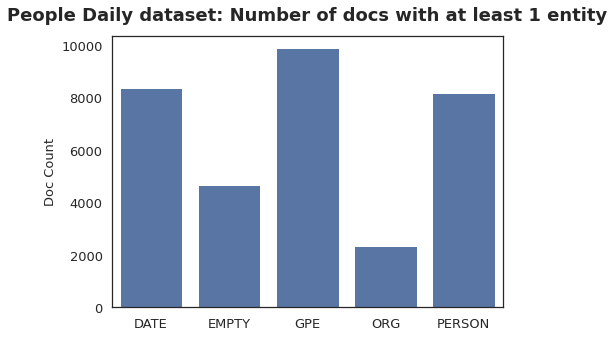

In [ ]:
plot_statistics(doc_count.keys(), doc_count.values(), x_label = "Entity Type", y_label = "Doc Count", title = "People Daily dataset: Number of docs with at least 1 entity")

Now we observe that the disparity between GPE and ORG is not as big as before. Nevertheless, there are still relatively few documents (~2.2K) that contain ORG.

we should also note that there are around 4.5K documents that are "EMPTY" or have zero entity types. We will still keep these documents in our dataset for training, otherwise the model may struggle with input text with no entities later at runtime.


Lastly, different datasets may follow different annotation schemes, so it's good to double check whether the definitions are consistent.

For the People's Daily dataset, it only contains GPE and not LOC entities, so we want to check whether the GPE entities include non-governing bodies and physical locations.

In [ ]:
#Check that GPE is inclusive of non-governing bodies
set(samples_dict['GPE'][:150])

{'上海',
 '东盟',
 '中华人民共和国',
 '中国',
 '俄罗斯',
 '内蒙古',
 '北京',
 '北京市',
 '台湾',
 '合肥市',
 '唐古拉山',
 '喜马拉雅山',
 '大泽',
 '天安门',
 '宁夏',
 '安多县',
 '安徽',
 '安徽省',
 '尼玛县',
 '山南',
 '拉萨',
 '新疆',
 '日喀则',
 '日本',
 '昌都',
 '法国',
 '淮河',
 '澳门',
 '甘肃',
 '石景山',
 '罗马',
 '美国',
 '苏州',
 '蚌埠',
 '西藏',
 '贵州',
 '贵州省',
 '贵阳',
 '那曲',
 '长安街',
 '长江路',
 '阿里',
 '青海',
 '香港',
 '黑龙江',
 '黔南',
 '黔南州'}

As seen from the samples above, the GPE entities in the People's Daily dataset do include non-governing bodies and physical locations. Thus, this is well-suited for our use-case.

## Train, validation, test split

We will split the dataset into 3, where the train set will be used to train the model, validation set will be used to select the best model and test set will be used for the final evaluation.

Before we do so, currently the entity lists we have are of varying lengths. Thus, we need to apply padding first based on the maximum length of an entity list.

In [6]:
def FindMaxLength(lst):
    """Get maximum length of an entity list"""
    maxList = max(lst, key = lambda i: len(i))
    maxLength = len(maxList)
    return maxList, maxLength

_, list_max_length = FindMaxLength(entities_list_split)

In [7]:
#Apply padding to all entity lists
for entity_label_list_split in entities_list_split:
  entity_label_list_split.extend([0] * (list_max_length - len(entity_label_list_split)))

In [ ]:
np.array(entities_list_split).shape

(19359, 186)

Now we see that each of our entity lists have a length of 186.

We can now proceed to do our train-val-test split. Given that the dataset is a multi-label one (each example text has not one but multiple labels), we have to account for this and split the dataset such that each of the datasets has a relatively equal proportion of entity types. 

This is important, because we wouldn't want a case where our train, validation or test set only contains one entity type.

In [8]:
def iterative_train_test_split_dataframe(X, y, test_size):
    """Split multi-label dataset into training and test sets"""
    df_index = np.expand_dims(X.index.to_numpy(), axis=1)
    X_train, y_train, X_test, y_test = iterative_train_test_split(df_index, y, test_size = test_size)
    X_train = X.loc[X_train[:,0]]
    X_test = X.loc[X_test[:,0]]
    return X_train, y_train, X_test, y_test

In [9]:
X_train, y_train, X_test, y_test = iterative_train_test_split_dataframe(pd.DataFrame(text_list_split), np.array(entities_list_split), test_size = 0.2)
X_val, y_val, X_test_final, y_test_final = iterative_train_test_split_dataframe(X_test, y_test, test_size = 0.5)

The ratio of the train:val:test split used is 80:10:10. This is because the dataset is relatively small, so it will be good have a bigger training set to train the model. 

In addition, the validation and test sets should still have at least 200 examples per entity type, which should still be sufficient.

In [10]:
print(len(X_train), len(X_val), len(X_test_final))

15487 1936 1936


In [11]:
#Create dictionary of index to label mapping
index_mapping = {v: k for k, v in label_mapping.items()}
index_mapping[0] = "EMPTY"
index_mapping

{1: 'DATE', 2: 'PERSON', 3: 'ORG', 4: 'GPE', 0: 'EMPTY'}

In [12]:
def count_doc_entity_type(target_dataset, index_mapping=index_mapping):
  """Count number of docs with at least 1 entity type, for training or test sets"""

  doc_count = init_dict_cnt()

  for target_list in target_dataset:
    if len(set(target_list)) == 1:
      doc_count["EMPTY"] += 1
    else:
      for label in set(target_list):
        if label != 0:
          doc_count[index_mapping[label]] += 1
  
  print(doc_count)

In [13]:
for i in [y_train, y_val, y_test_final]:
  count_doc_entity_type(i)

{'EMPTY': 3721, 'DATE': 6703, 'PERSON': 6550, 'ORG': 1909, 'GPE': 7881}
{'EMPTY': 465, 'DATE': 819, 'PERSON': 789, 'ORG': 222, 'GPE': 989}
{'EMPTY': 465, 'DATE': 851, 'PERSON': 820, 'ORG': 223, 'GPE': 1000}


We can see that after the split, each dataset has a relatively equal proportion of entity types.

## Using baseline pretrained model

Now that we have our train/val/test sets, we can proceed with the modeling. We will first load a pretrained Chinese NER model from SpaCy and evaluate it both qualitatively and quantitatively.

In [ ]:
nlp_baseline = spacy.load("zh_core_web_sm")

In [ ]:
sample1 = "陈俊勇（47岁，科技业人员）本月底将到印度尼西亚旅游，加上从未确诊，因此决定继续戴口罩。他说：“我会观察我国未来几个月的确诊病例，如果情况维持或改善，我可能就不戴口罩了。"
sample2 = "另外，与其他公众一样，公交职员也可选择不戴口罩，不过据《联合早报》观察，大部分巴士车长开车或在转换站走动时仍戴着口罩。《联合早报》记者走访五个地铁站发现，绝大多数工作人员都戴着口罩。在地铁站巡逻的公共交通保安指挥处（Transcom）警员也同样戴着口罩。"
sample3 = "在开战一周年之际，《联合早报》记者前往波兰采访失去家园的乌克兰难民。这期的早报播客《东谈西论》，听《联合早报》中国新闻组副主任沈泽玮与国际组记者廖慧婷分享他们欧洲之行的所见所闻。《东谈西论》主持人韩咏红也邀请南京大学国际关系学院执行院长朱锋教授回顾俄乌战争一周年对世界格局带来的影响，并且展望战局的下一步发展 。"
sample_list = [sample1, sample2, sample3]

def render_ner_samples(ner_model, sample_list):
    """Apply ner model to a sample list and visualize extracted entities"""
    for index, sample in enumerate(sample_list):
      print("doc: " + str(index + 1))
      doc = ner_model(sample)
      displacy.render(doc, style="ent", jupyter=True)  
      print("\n")

In [ ]:
render_ner_samples(nlp_baseline, sample_list)

doc: 1




doc: 2




doc: 3


From visualizing the entities the model extracted from the samples, it seems to be doing a pretty good job for PERSON and GPE/LOC entities. However, it's making several mistakes for ORG, such as wrongly tagging "俄乌战争" or Russian-Ukrainian War as ORG.

We can evaluate its performance more quantitatively by looking at F1-score, precision and recall per entity type.

In [ ]:
def evaluate_per_category_metrics(ner_model, spacy_data, indexes):
    """Compute F1 score, Precision and Recall for the entities we're interested in"""
    scorer = Scorer()
    examples = []

    for index in indexes:
        text = spacy_data[index]['text'] 
        labels = spacy_data[index]['entities']
        doc_gold_text = ner_model.make_doc(text)
        example = Example.from_dict(doc_gold_text, {"entities": labels})
        example.predicted = ner_model(text)
        examples.append(example)
        
    return scorer.score(examples)['ents_per_type']

entity_type_scores = evaluate_per_category_metrics(nlp_baseline, spacy_data, X_test_final.index)

/usr/local/lib/python3.8/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "实现祖国的完全统一,是海内外全体中国人的共同心愿。通过中葡双方的合作和努力,按照“一国两制”方针和澳..." with entities "[(16, 18, 'GPE'), (49, 51, 'GPE'), (57, 65, 'DATE'...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "『八五』以来,胜利油田在渤海湾极浅海海域展开了大规模勘探开发会战。一九九七年初,胜利油田提出了奋战一..." with entities "[(12, 15, 'GPE'), (33, 38, 'DATE'), (91, 94, 'PERS...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be ali

In [ ]:
for entity_type in ['PERSON', 'GPE', 'ORG']:
  print(entity_type + ":")
  print(entity_type_scores[entity_type])

PERSON:
{'p': 0.8052347959969207, 'r': 0.7402689313517339, 'f': 0.7713864306784659}
GPE:
{'p': 0.7966011683483802, 'r': 0.5729564553093965, 'f': 0.6665185514330149}
ORG:
{'p': 0.20293609671848015, 'r': 0.7389937106918238, 'f': 0.31842818428184283}


We see that the model has a somewhat low Recall for GPE, which means it wasn't able to identify all the GPEs in the text.

It also has a very low Precision for ORG, which explains the above case we saw earlier, where it wrongly tagged "俄乌战争" or Russian-Ukrainian War as ORG.

## Finetuning: NER model

To improve the model, we can fine-tune the pretrained model by training it on the People's Daily dataset.

First, we'll make use of the list of dictionaries we created earlier, and convert them into DocBin objects, which is required for SpaCy training.

In [ ]:
def create_spacy_docbin(spacy_data, indexes, model_type = "ner", docbin_type = "train", lang = "zh"):
  """Create DocBin object for Spacy training"""

  # Load a new spacy model
  nlp = spacy.blank(lang) 
  # Create new docbin object
  doc_bin = DocBin()   

  DOCBIN_FILE = docbin_type + "_" + model_type + ".spacy"

  for training_index in tqdm(indexes):
      text = spacy_data[training_index]['text'] 
      labels = spacy_data[training_index]['entities']           
      doc = nlp.make_doc(text)                                      #convert text to doc object
      spans = []
      for start, end, label in labels:
          span = doc.char_span(start, end, label=label, alignment_mode="contract")   #create span object for each entity
          if span is None:
              print("Skipping entity")
          else:
              spans.append(span)
      
      if model_type != "ner":                           #Treatment for SpanCat model
        group = SpanGroup(doc, name="sc", spans=spans)               
        doc.spans["sc"] = group
      else:                                           
        filtered_ents = filter_spans(spans)               #pass list of entities to filter_spans function (checks for duplicate entities and do other sanity checks)
        doc.ents = filtered_ents                          #store final list of entities as doc.ents variable 
      doc_bin.add(doc)                           #Append doc to docbin object
      
  doc_bin.to_disk(DOCBIN_FILE) 

create_spacy_docbin(spacy_data, X_train.index)
create_spacy_docbin(spacy_data, X_val.index, docbin_type = "validation")

100%|██████████| 1936/1936 [00:01<00:00, 1716.19it/s]


Next, we'll set up the config files required, before training the model.

In [ ]:
#Populate base_config
!python3 -m spacy init fill-config base_config_ner.cfg config_ner.cfg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-22 14:43:18.651730: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-22 14:43:18.651834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-22 14:43:18.651852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [ ]:
#Change max_epochs to 7
#Train spacy model
!python3 -m spacy train config_ner.cfg --output ./ --paths.train ./train_ner.spacy --paths.dev ./validation_ner.spacy 

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-22 14:44:01.825076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-22 14:44:01.825205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-22 14:44:01.825228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

After training for around 6 epochs, the model was able to achieve a validation F1-score of around 93%. We can further evaluate the model qualitatively and quantitatively.

In [ ]:
#Load best model, need to rename default "model-best" folder
ner_best = spacy.load("ner-model-best")      

In [ ]:
render_ner_samples(ner_best, sample_list)

doc: 1




doc: 2




doc: 3


Compared to the baseline model, it seems that the finetuned model has some improvements as it is no longer tagging "俄乌战争" as ORG. However, it is still making some mistakes, as it tagged "联合早" as ORG, when it should have tagged "联合早报" instead.

This might be due to 2 reasons:
- The number of examples with ORG is pretty low and may be insufficient for the model to learn well. It will be good to add more examples for ORG to improve the model's performance.
- The samples are from a newspaper in Singapore, while the model was trained on news data from China. "联合早报" is an organization in Singapore, therefore it makes sense that the model may not recognize such terms. If we want the model to perform well specifically for Singaporean news, it will be good to add Singapore news examples to the training data.

In [ ]:
entity_type_scores_best = evaluate_per_category_metrics(ner_best, spacy_data, X_test.index)
for entity_type in ['PERSON', 'GPE', 'ORG']:
  print(entity_type + ":")
  print(entity_type_scores_best[entity_type])

PERSON:
{'p': 0.9148936170212766, 'r': 0.8662056524353577, 'f': 0.8898841698841699}
GPE:
{'p': 0.9563235852639574, 'r': 0.9026707295214196, 'f': 0.9287229137851545}
ORG:
{'p': 0.9462989840348331, 'r': 0.9644970414201184, 'f': 0.9553113553113555}


Nevertheless, when we evaluate on the test set, it seems that recall for GPE and precision for ORG has improved substantially. 

If we apply the model to unseen People's Daily examples or other China newspaper examples, the model should be able to perform well.

In [ ]:
ner_best.to_disk(FOLDER_PATH + "best-ner-model") 

## Finetuning: SpanCategorizer model

So far, the finetuned NER model we developed seems to have pretty good performance. However, the NER model in SpaCy uses a transition-based approach, rather than a probabilistic one, and therefore is unable to return confidence scores.

Thus, if we want to obtain confidence scores for each entity type prediction, we have to use the SpanCategorizer model in SpaCy instead.

In [16]:
create_spacy_docbin(spacy_data, X_train.index, model_type = "spancat")
create_spacy_docbin(spacy_data, X_val.index, model_type = "spancat", docbin_type = "validation")

100%|██████████| 1936/1936 [00:03<00:00, 520.42it/s]


In [17]:
#Populate base_config
!python3 -m spacy init fill-config base_config_spancat.cfg config_spancat.cfg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-23 16:04:42.827066: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-23 16:04:42.827174: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-23 16:04:42.827193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [18]:
#Change max_epochs to 7
!python3 -m spacy train config_spancat.cfg --output ./ --paths.train ./train_spancat.spacy --paths.dev ./validation_spancat.spacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-23 16:05:29.695138: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-23 16:05:29.695280: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-23 16:05:29.695303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

After training the model for 6 epochs, the model has an F1-score of around 83%, which is lower than the finetuned NER model. This is because the NER model has stronger constraints, which can help it make better predictions.

Nevertheless, we can still improve the SpanCategorizer model's performance, by increasing the model size or adding more examples to the training dataset.

In [19]:
#Load best model, need to rename default "model-best" folder
spancat_best = spacy.load("spancat-model-best")                 

In [20]:
#Print confidence score for prediction
sample_doc = spancat_best(sample_list[2])
sample_spans = sample_doc.spans["sc"]
for span, confidence in zip(sample_spans, sample_spans.attrs["scores"]):
    print(span.text, span.label_, confidence)

波兰 GPE 0.9934057
中国 GPE 0.99924856
欧洲 GPE 0.99932325
南京 GPE 0.99565387
朱锋 PERSON 0.9996153
乌克兰 GPE 0.99484974
沈泽玮 PERSON 0.9980667
廖慧婷 PERSON 0.9993088
韩咏红 PERSON 0.99929595


When applying the SpanCategorizer model to the 3rd sample, unlike the pretrained model and finetuned NER model, it doesn't detect any ORG entities. Nevertheless, it still performs well for PERSON and GPE entities, and is able to provide the confidence scores.

Now that we have a model that can extract entities and provide confidence scores, we can save the model to be used in our API later.

In [ ]:
spancat_best.to_disk(FOLDER_PATH + "best-spancat-model")